# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

In [1]:
#modified
#!pip install -qU langchain_openai langchain_core==0.2.38 langchain

#orig
!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langgraph 0.2.16 requires langchain-core<0.3,>=0.2.27, but you have langchain-core 0.3.6 which is incompatible.
langchain-huggingface 0.0.3 requires langchain-core<0.3,>=0.1.52, but you have langchain-core 0.3.6 which is incompatible.
ragas 0.1.20 requires langchain-core<0.3, but you have langchain-core 0.3.6 which is incompatible.
langgraph-checkpoint 1.0.6 requires langchain-core<0.3,>=0.2.22, but you have langchain-core 0.3.6 which is incompatible.
langchain-qdrant 0.1.3 requires langchain-core<0.3,>=0.1.52, but you have langchain-core 0.3.6 which is incompatible.


In [1]:
import langchain_core
langchain_core.__version__

'0.3.6'

In [5]:
!pip install -qU ragas

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-cohere 0.3.0 requires langchain-core<0.4,>=0.3.0, but you have langchain-core 0.2.41 which is incompatible.
langchain-experimental 0.3.2 requires langchain-community<0.4.0,>=0.3.0, but you have langchain-community 0.2.17 which is incompatible.
langchain-experimental 0.3.2 requires langchain-core<0.4.0,>=0.3.6, but you have langchain-core 0.2.41 which is incompatible.


In [1]:
!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langgraph 0.2.16 requires langchain-core<0.3,>=0.2.27, but you have langchain-core 0.3.6 which is incompatible.
langchain-huggingface 0.0.3 requires langchain-core<0.3,>=0.1.52, but you have langchain-core 0.3.6 which is incompatible.
langgraph-checkpoint 1.0.6 requires langchain-core<0.3,>=0.2.22, but you have langchain-core 0.3.6 which is incompatible.
langchain-qdrant 0.1.3 requires langchain-core<0.3,>=0.1.52, but you have langchain-core 0.3.6 which is incompatible.


We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [3]:
!pip install -qU qdrant-client

We'll also provide our OpenAI key, as well as our Cohere API key.

In [5]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [28]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [5]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2024-09-26 19:45:40--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0.004s  

2024-09-26 19:45:40 (4.94 MB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2024-09-26 19:45:41--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14747 (14K) [text/plain]
Sa

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [7]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [8]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2024, 9, 24, 11, 14, 51, 502326)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [9]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [10]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [11]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-3.5-turbo` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [12]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI()

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [13]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [17]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the reviews provided.'

In [18]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is a review with a rating of 10. Here is the URL to that review:\n'/review/rw4854296/?ref_=tt_urv'"

In [19]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'John Wick is about an ex-hitman who comes out of retirement to seek vengeance against the gangsters who killed his dog and took everything from him. The story involves intense action, shootouts, and thrilling fights as John Wick becomes the target of hitmen and must unleash a maelstrom of destruction to survive.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [29]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [16]:
naive_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [22]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Opinions on John Wick seem to be varied. Some people really enjoyed the action and style of the movie, while others found it lacking in substance and plot. So, it appears that not everyone liked John Wick.'

In [23]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I'm sorry, but there are no reviews with a rating of 10 in the provided context."

In [24]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"John Wick is a movie known for its beautifully choreographed action, emotional setup, and Keanu Reeves' performance. It has been praised for being a thrilling ride for action lovers."

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [30]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

/opt/anaconda3/envs/llmops-course-aie4/lib/python3.11/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


Let's create our chain again, and see how this does!

In [31]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [27]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the reviews provided.'

In [28]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is a review with a rating of 10. Here is the URL to that review: '/review/rw4854296/?ref_=tt_urv'"

In [29]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the main character, played by Keanu Reeves, seeks revenge on those who killed his dog and took everything from him. The story involves him coming out of retirement as a hitman to track down gangsters and face professional killers after him.'

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [32]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [33]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [52]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, it seems that the general consensus is that people liked John Wick. The film received positive feedback for its slickness, action sequences, and Keanu Reeves' performance. Reviewers praised the movie for being fun, entertaining, and well-executed. Therefore, it can be concluded that people generally liked John Wick."

In [33]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I'm sorry, but there are no reviews with a rating of 10 in the provided context."

In [34]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the John Wick series, Keanu Reeves plays the character John Wick, a retired assassin who comes out of retirement to seek revenge after someone kills his dog and steals his car. The storyline involves a lot of action, violence, and assassins as John Wick goes on a mission to settle old debts and take down his enemies.'

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [14]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [15]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

/var/folders/4m/qys1srq936x7nlb09bpm1dzc0000gn/T/ipykernel_87858/3574430551.py:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [17]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [18]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [19]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [40]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"People's opinions on John Wick seem to be divided. Some love the series and find it consistent and well-received, while others find it horrible and nonsensical. So, it's hard to say if people generally like John Wick."

In [41]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review: /review/rw4854296/?ref_=tt_urv'

In [42]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, the main character, played by Keanu Reeves, is a retired assassin who comes out of retirement after his dog is killed and his car is stolen. He is forced back into the world of assassins when he is called on to pay off an old debt by helping take over the Assassin's Guild. This leads to a lot of action and violence as John Wick travels to Italy, Canada, and Manhattan to complete his mission."

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [34]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [35]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [45]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, it seems that the majority of people enjoyed the John Wick movies. The reviews praise the action sequences, Keanu Reeves' performance, and the overall style of the films. Some reviewers even consider it one of the best action films they've seen. Therefore, it can be said that people generally liked John Wick."

In [46]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is one review with a rating of 10. Here is the URL to that review: '/review/rw4854296/?ref_=tt_urv'."

In [47]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'John Wick is an ex-hitman who comes out of retirement to seek vengeance on the gangsters who killed his dog and took everything from him. This leads to a series of violent events and action-packed sequences in the movie.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

In [48]:
!pip install -qU langchain_experimental

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [50]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [51]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [52]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [53]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [54]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [54]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the reviews provided.'

In [55]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3". Here is the URL to that review: \'/review/rw4854296/?ref_=tt_urv\'.'

In [56]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the movie John Wick, an ex-hitman comes out of retirement to seek vengeance on the gangsters who killed his dog and took everything from him. This leads to a series of violent and action-packed events as John Wick faces off against various adversaries.'

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

## Overall Summary
- I combined the results for different retrievers up here. The code of how to generate the results are showing in later cells.
- It's clear that each retriever has its strengths and weaknesses across various performance metrics, cost, and latency. 'Ensemble' method shows good performance, but is the most expensive and also has the highest average latency per run. 
- The choice of the best retriever depends on the specific requirements of the application:
    - If the highest performance with less concern for cost and latency is needed, 'ensemble' stands out as the best choice due to its superior accuracy and relevancy.
    - If cost efficiency is crucial without significantly compromising performance, 'contextual compression' offers a good middle ground with reasonable costs and high performance metrics. But remember, you need to pay more to Cohere to upgrad your plan.
    - For scenarios where speed is critical, 'bm25' may be the best option due to its low latency, despite its lower performance in some metrics compared to others.
    - Overall, while 'ensemble' provides the best accuracy, it comes at the cost of higher operational expenses and slower response times. If these drawbacks are acceptable within the operational context, it should be the preferred choice. However, if budget or response time constraints are tighter, alternatives like 'contextual compression' or 'bm25' might be more suitable.
    - (In below cells I also compared semantic chunker on VS off, with on, we got better performace on the retrieval side, along with a higher answer_relevancy.)

In [63]:
import pandas as pd
data = {
    'Metric': ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision', 
               'answer_correctness','avg latency per run (s)','cost $ for total run (19 traces)'],
    'naive': [0.802592, 0.965581, 0.785088, 0.870276, 0.765211, 1.63, 0.035147],
    'bm25': [0.643797, 0.818162, 0.609649, 0.679825, 0.670134, 1.17, 0.0129795],
    'contextual_compression': [0.955000, 0.974786, 0.900000, 0.925000, 0.771489, 1.88, 0.0116043],
    'multi_query': [0.926984, 0.914887, 0.754386, 0.856171, 0.777324, 3.49, 0.045859],
    'parent_document': [0.671199, 0.911416, 0.574561, 0.776316, 0.652208, 1.41, 0.007381],
    'ensemble': [1.000000, 0.977313, 0.950000, 0.704824, 0.765512, 5.01, 0.058285349]

}

df = pd.DataFrame(data)
df 


,Metric,naive,bm25,contextual_compression,multi_query,parent_document,ensemble
0,faithfulness,0.802592,0.643797,0.955000,0.926984,0.671199,1.000000
1,answer_relevancy,0.965581,0.818162,0.974786,0.914887,0.911416,0.977313
2,context_recall,0.785088,0.609649,0.900000,0.754386,0.574561,0.950000
3,context_precision,0.870276,0.679825,0.925000,0.856171,0.776316,0.704824
4,answer_correctness,0.765211,0.670134,0.771489,0.777324,0.652208,0.765512
5,avg latency per run (s),1.630000,1.170000,1.880000,3.490000,1.410000,5.010000
6,cost $ for total run (19 traces),0.035147,0.012979,0.011604,0.045859,0.007381,0.058285


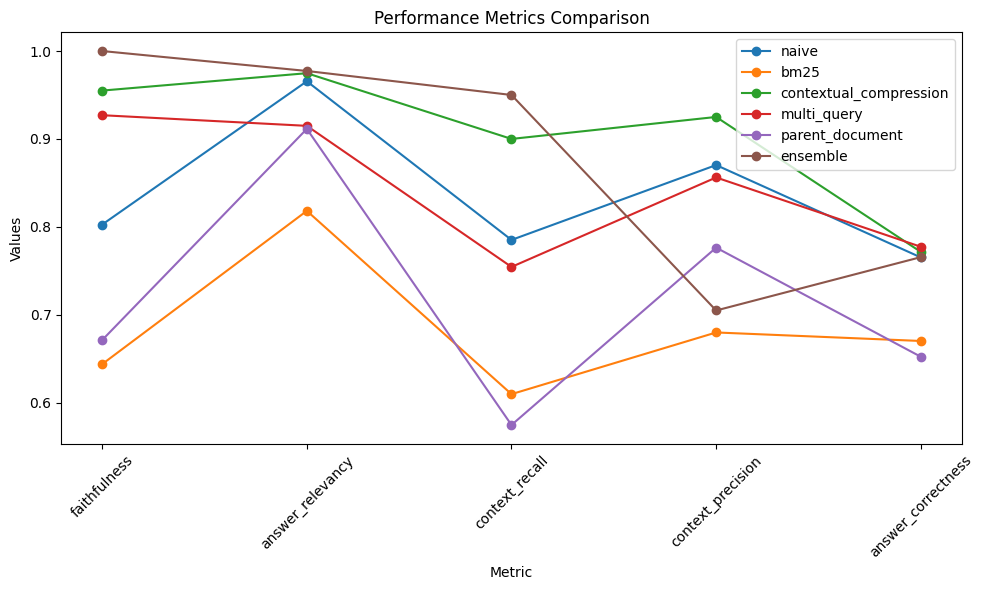

In [67]:
import matplotlib.pyplot as plt

# First Plot - Performance Metrics Comparison
plt.figure(figsize=(10, 6))
for col in df.columns[1:]:
    plt.plot(df['Metric'][:5], df[col][:5], marker='o', label=col)
plt.xlabel('Metric')
plt.ylabel('Values')
plt.title('Performance Metrics Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

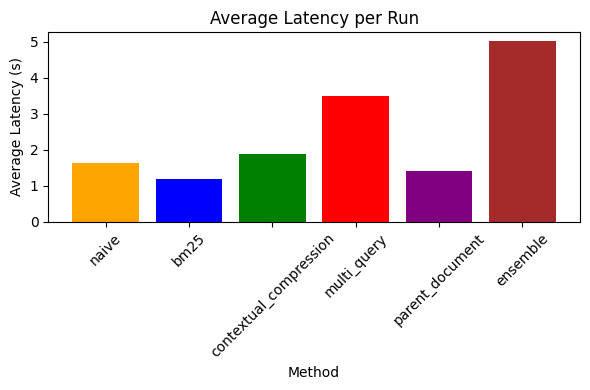

In [75]:
# Second Plot - Average Latency per Run
plt.figure(figsize=(6, 4))
heights = df.iloc[5, 1:].values
bars = df.columns[1:]
plt.bar(bars, heights, color=['orange', 'blue', 'green', 'red', 'purple', 'brown'])
plt.xlabel('Method')
plt.xticks(rotation=45)
plt.ylabel('Average Latency (s)')
plt.title('Average Latency per Run')
plt.tight_layout()
plt.show()

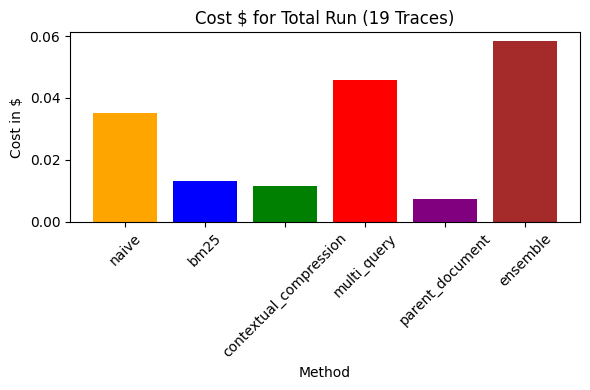

In [74]:
# Third Plot - Cost $ for Total Run (19 Traces)
plt.figure(figsize=(6, 4))
heights = df.iloc[6, 1:].values
plt.bar(bars, heights, color=['orange', 'blue', 'green', 'red', 'purple', 'brown'])
plt.xlabel('Method')
plt.xticks(rotation=45)
plt.ylabel('Cost in $')
plt.title('Cost $ for Total Run (19 Traces)')
plt.tight_layout()
plt.show()

## Ragas

In [ ]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-3.5-turbo")
critic_llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

num_qa_pairs = 20 # You can reduce the number of QA pairs to 5 if you're experiencing rate-limiting issues

testset = generator.generate_with_langchain_docs(documents, num_qa_pairs, distributions)
testset_df = testset.to_pandas()
testset_df.to_csv("ragas_testset.csv")

## Evaluation

In [20]:
import pandas as pd

testset_df = pd.read_csv("ragas_testset.csv", index_col=0)
test_questions = testset_df["question"].values.tolist()
test_groundtruths = testset_df["ground_truth"].values.tolist()

In [23]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
)

metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
]

In [17]:
import os
import getpass

from uuid import uuid4

unique_id = uuid4().hex[0:8]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"]="AIE4-W7-reranker"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass('Enter your LangSmith API key: ')

### Naive_chain

In [40]:
from langsmith import traceable
@traceable(
    run_type="llm",
    name="OpenAI Call Decorator",
    project_name="AIE4-W7-Naive Chain"
)
def run_langsmith_eva(retrieval_chain):
    answers = []
    contexts = []

    for question in test_questions:
        response = retrieval_chain.invoke({"question" : question})
        answers.append(response["response"].content)
        contexts.append([context.page_content for context in response["context"]])

    retrieval_chain_response_dataset = Dataset.from_dict({
        "question" : test_questions,
        "answer" : answers,
        "contexts" : contexts,
        "ground_truth" : test_groundtruths
    })
    return retrieval_chain_response_dataset
naive_retrieval_chain_response_dataset = run_langsmith_eva(naive_retrieval_chain)
#avg latency per run : 1.63
#cost for total run (19 traces): $0.035147

In [14]:
naive_retrieval_chain_retrieval_results = evaluate(naive_retrieval_chain_response_dataset, metrics)

Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

In [15]:
df1 = pd.DataFrame(list(naive_retrieval_chain_retrieval_results.items()), columns=['Metric', 'naive'])
df1

,Metric,naive
0,faithfulness,0.802592
1,answer_relevancy,0.965581
2,context_recall,0.785088
3,context_precision,0.870276
4,answer_correctness,0.765211


### BM25

In [42]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [43]:
from langsmith import traceable
@traceable(
    run_type="llm",
    name="OpenAI Call Decorator",
    project_name="AIE4-W7-bm25"
)
def run_langsmith_eva(retrieval_chain):
    answers = []
    contexts = []

    for question in test_questions:
        response = retrieval_chain.invoke({"question" : question})
        answers.append(response["response"].content)
        contexts.append([context.page_content for context in response["context"]])

    retrieval_chain_response_dataset = Dataset.from_dict({
        "question" : test_questions,
        "answer" : answers,
        "contexts" : contexts,
        "ground_truth" : test_groundtruths
    })
    return retrieval_chain_response_dataset
bm25_retrieval_chain_response_dataset = run_langsmith_eva(bm25_retrieval_chain)
#avg latency per run : 1.17s
#cost for total run (19 traces): $0.0129795

In [15]:
bm25_retrieval_chain_retrieval_results = evaluate(bm25_retrieval_chain_response_dataset, metrics)
df2 = pd.DataFrame(list(bm25_retrieval_chain_retrieval_results.items()), columns=['Metric', 'bm25'])
df2

Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

,Metric,bm25
0,faithfulness,0.643797
1,answer_relevancy,0.818162
2,context_recall,0.609649
3,context_precision,0.679825
4,answer_correctness,0.670134


### reranker

In [46]:
from langsmith import traceable
@traceable(
    run_type="llm",
    name="OpenAI Call Decorator",
    project_name="AIE4-W7-Reranker"
)
def run_langsmith_eva(retrieval_chain):
    answers = []
    contexts = []

    for question in test_questions[0:10]:
        response = retrieval_chain.invoke({"question" : question})
        answers.append(response["response"].content)
        contexts.append([context.page_content for context in response["context"]])

    retrieval_chain_response_dataset = Dataset.from_dict({
        "question" : test_questions[0:10],
        "answer" : answers,
        "contexts" : contexts,
        "ground_truth" : test_groundtruths[0:10]
    })
    return retrieval_chain_response_dataset
contextual_compression__retrieval_chain_response_dataset = run_langsmith_eva(contextual_compression_retrieval_chain)
#avg latency per run : 1.88s
#cost for total run (10 traces): $0.0061075
#estimated cost for total run (19 traces): $0.01160425

In [23]:
contextual_compression_retrieval_chain_retrieval_results = evaluate(contextual_compression_retrieval_chain_response_dataset, metrics)
df3 = pd.DataFrame(list(contextual_compression_retrieval_chain_retrieval_results.items()), columns=['Metric', 'contextual_compression'])
df3

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

,Metric,contextual_compression
0,faithfulness,0.955000
1,answer_relevancy,0.974786
2,context_recall,0.900000
3,context_precision,0.925000
4,answer_correctness,0.771489


### multi-query

In [53]:
from langsmith import traceable
@traceable(
    run_type="llm",
    name="OpenAI Call Decorator",
    project_name="AIE4-W7-Multi-Query Retriever"
)
def run_langsmith_eva(retrieval_chain):
    answers = []
    contexts = []

    for question in test_questions:
        response = retrieval_chain.invoke({"question" : question})
        answers.append(response["response"].content)
        contexts.append([context.page_content for context in response["context"]])

    retrieval_chain_response_dataset = Dataset.from_dict({
        "question" : test_questions,
        "answer" : answers,
        "contexts" : contexts,
        "ground_truth" : test_groundtruths
    })
    return retrieval_chain_response_dataset
multi_query_retrieval_chain_response_dataset = run_langsmith_eva(multi_query_retrieval_chain)

#avg latency per run : 3.49s
#cost for total run (19 traces): $0.045859

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 19
})

In [22]:
os.environ["LANGCHAIN_TRACING_V2"] = "flase"
multi_query_retrieval_chain_retrieval_results = evaluate(multi_query_retrieval_chain_response_dataset, metrics)
df4 = pd.DataFrame(list(multi_query_retrieval_chain_retrieval_results.items()), columns=['Metric', 'multi_query'])
df4


Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

,Metric,multi_query
0,faithfulness,0.926984
1,answer_relevancy,0.914887
2,context_recall,0.754386
3,context_precision,0.856171
4,answer_correctness,0.777324


### Parent Document Retriever

In [ ]:
from langsmith import traceable
@traceable(
    run_type="llm",
    name="OpenAI Call Decorator",
    project_name="AIE4-W7-Parent Document"
)
def run_langsmith_eva(retrieval_chain):
    answers = []
    contexts = []

    for question in test_questions:
        response = retrieval_chain.invoke({"question" : question})
        answers.append(response["response"].content)
        contexts.append([context.page_content for context in response["context"]])

    retrieval_chain_response_dataset = Dataset.from_dict({
        "question" : test_questions,
        "answer" : answers,
        "contexts" : contexts,
        "ground_truth" : test_groundtruths
    })
    return retrieval_chain_response_dataset
parent_document_retrieval_chain_response_dataset = run_langsmith_eva(parent_document_retrieval_chain)
#avg latency per run : 1.41s
#cost for total run (19 traces): $0.007381

In [27]:
parent_document_retrieval_chain_retrieval_results = evaluate(parent_document_retrieval_chain_response_dataset, metrics)
df5 = pd.DataFrame(list(parent_document_retrieval_chain_retrieval_results.items()), columns=['Metric', 'parent_document'])
df5

Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

,Metric,parent_document
0,faithfulness,0.671199
1,answer_relevancy,0.911416
2,context_recall,0.574561
3,context_precision,0.776316
4,answer_correctness,0.652208


### Ensemble Retriever


In [37]:
from langsmith import traceable
@traceable(
    run_type="llm",
    name="OpenAI Call Decorator",
    project_name="AIE4-W7-Ensemble Retriever"
)
def run_langsmith_eva(retrieval_chain):
    answers = []
    contexts = []

    for question in test_questions[0:10]:
        response = retrieval_chain.invoke({"question" : question})
        answers.append(response["response"].content)
        contexts.append([context.page_content for context in response["context"]])

    retrieval_chain_response_dataset = Dataset.from_dict({
        "question" : test_questions[0:10],
        "answer" : answers,
        "contexts" : contexts,
        "ground_truth" : test_groundtruths[0:10]
    })
    return retrieval_chain_response_dataset
ensemble_retrieval_chain_response_dataset = run_langsmith_eva(ensemble_retrieval_chain)
#avg latency per run : 5.01
#cost for total run (10 traces): $0.0306765
#estimated cost for total run (19 traces): $0.058285349

In [39]:
ensemble_retrieval_chain_retrieval_results = evaluate(ensemble_retrieval_chain_response_dataset, metrics)
df6 = pd.DataFrame(list(ensemble_retrieval_chain_retrieval_results.items()), columns=['Metric', 'ensemble'])
df6

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

,Metric,ensemble
0,faithfulness,1.000000
1,answer_relevancy,0.977313
2,context_recall,0.950000
3,context_precision,0.704824
4,answer_correctness,0.765512


### Semantic ON VS OFF

In [76]:
os.environ["LANGCHAIN_TRACING_V2"] = "false"

In [77]:
def run_langsmith_eva(retrieval_chain):
    answers = []
    contexts = []

    for question in test_questions:
        response = retrieval_chain.invoke({"question" : question})
        answers.append(response["response"].content)
        contexts.append([context.page_content for context in response["context"]])

    retrieval_chain_response_dataset = Dataset.from_dict({
        "question" : test_questions,
        "answer" : answers,
        "contexts" : contexts,
        "ground_truth" : test_groundtruths
    })
    return retrieval_chain_response_dataset
semantic_retrieval_chain_response_dataset = run_langsmith_eva(semantic_retrieval_chain)

In [81]:
semantic_retrieval_chain_retrieval_results = evaluate(semantic_retrieval_chain_response_dataset, metrics)
df7 = pd.DataFrame(list(semantic_retrieval_chain_retrieval_results.items()), columns=['Metric', 'semantic_on'])
df7

Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

,Metric,semantic_on
0,faithfulness,0.705201
1,answer_relevancy,0.873223
2,context_recall,0.741228
3,context_precision,0.730463
4,answer_correctness,0.683373


In [79]:
semantic_off_retrieval_chain = (
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [80]:
semantic_off_retrieval_chain_response_dataset = run_langsmith_eva(semantic_off_retrieval_chain)

In [82]:
semantic_off_retrieval_chain_retrieval_results = evaluate(semantic_off_retrieval_chain_response_dataset, metrics)
df8 = pd.DataFrame(list(semantic_off_retrieval_chain_retrieval_results.items()), columns=['Metric', 'semantic_off'])
df8

Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

,Metric,semantic_off
0,faithfulness,0.733835
1,answer_relevancy,0.915953
2,context_recall,0.811404
3,context_precision,0.881931
4,answer_correctness,0.712900
